# Introduction: DynamicalSystems.jl

This notebook serves as an introduction to the DynamicalSystems.jl software library for nonlinear dynamics and nonlinear timeseries analysis. In short, this notebook:

- describes the library
- provides an overview of its contents, 
- gives a short tutorial on how to use it within circa 20 minutes
- shows how to use an interactive GUI window that allows evolving a dynamical system and changing some of its parameters during the live evolution

**Versions:** Please ensure you have the following packages installed, with these versions or newer:

In [4]:
import Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.status(["DynamicalSystems", "CairoMakie", "GLMakie", "OrdinaryDiffEq"]; mode = Pkg.PKGMODE_MANIFEST)

  Activating project at `c:\Users\datse\OneDrive - University of Exeter\Teaching\NonlinearDynamicsComplexSystemsCourses`


Status `C:\Users\datse\OneDrive - University of Exeter\Teaching\NonlinearDynamicsComplexSystemsCourses\Manifest.toml`
  [13f3f980] CairoMakie v0.10.11
  [61744808] DynamicalSystems v3.2.1
  [e9467ef8] GLMakie v0.8.11
  [1dea7af3] OrdinaryDiffEq v6.58.0


In [2]:
VERSION # the Julia version

v"1.9.1"

Quick theme change for plotting in zoomed-in Jupyter notebooks:

In [3]:
using CairoMakie
update_theme!(resolution = (500, 300), fontsize = 16)

# DynamicalSystems.jl

In [ ]:
using DynamicalSystems
@doc DynamicalSystems

The section that follows is a verbatim copy of the online [overarching tutorial for **DynamicalSystems.jl**](https://juliadynamics.github.io/DynamicalSystems.jl/latest/tutorial/). It has two goals: 

1. To teach you "the ropes" of DynamicalSystems.jl in about 20 minutes.
2. To give you an idea of all the subpackages that go into DynamicalSystems.jl. This can be a bit overwhelming depending on your familiarity with nonlinear dynamics, but do not worry if this is so. Followup lectures go in more depth, and explain in greater length, the subpackages.


## Core components

The individual packages that compose `DynamicalSystems` interact flawlessly with each other because of the following two components:

1. The `StateSpaceSet`, which represents numerical data. They can be observed or measured from experiments, sampled trajectories of dynamical systems, or just unordered sets in a state space. A `StateSpaceSet` is a container of equally-sized points, representing multivariate timeseries or multivariate datasets. Timeseries, which are univariate sets, are represented by the `AbstractVector{<:Real}` Julia base type.
2. The `DynamicalSystem`, which is the abstract representation of a dynamical system with a known dynamic evolution rule. `DynamicalSystem` defines an extendable interface, but typically one uses concrete implementations such as `DeterministicIteratedMap` or `CoupledODEs`.



## Making dynamical systems

In the majority of cases, to make a dynamical system one needs three things:

1. The dynamic rule `f`: A Julia function that provides the instructions of how to evolve the dynamical system in time.
2. The state `u`: An array-like container that contains the variables of the dynamical system and also defines the starting state of the system.
3. The parameters `p`: An arbitrary container that parameterizes `f`.

For most concrete implementations of `DynamicalSystem` there are two ways of defining `f, u`.
The distinction is done on whether `f` is defined as an in-place (iip) function or out-of-place (oop) function.

* **oop** : `f` **must** be in the form `f(u, p, t) -> out`
    which means that given a state `u::SVector{<:Real}` and some parameter container
    `p` it returns the output of `f` as an `SVector{<:Real}` (static vector).
* **iip** : `f` **must** be in the form `f!(out, u, p, t)`
    which means that given a state `u::AbstractArray{<:Real}` and some parameter container `p`,
    it writes in-place the output of `f` in `out::AbstractArray{<:Real}`.
    The function **must** return `nothing` as a final statement.

`t` stands for current time in both cases.
**iip** is suggested for systems with high dimension and **oop** for small.
The break-even point is between 10 to 100 dimensions but should be benchmarked
on a case-by-case basis as it depends on the complexity of `f`.

### Example: Henon map
Let's make the Henon map, defined as
$$
\begin{aligned}
x_{n+1} &= 1 - ax^2_n+y_n \\
y_{n+1} & = bx_n
\end{aligned}
$$
with parameters $a = 1.4, b = 0.3$.

First, we define the dynamic rule as a standard Julia function. Since the dynamical system is only two-dimensional, we should use the _out-of-place_ form that returns an `SVector` with the next state:


In [4]:
using DynamicalSystems

function henon_rule(u, p, n) # here `n` is "time", but we don't use it.
    x, y = u # system state
    a, b = p # system parameters
    xn = 1.0 - a*x^2 + y
    yn = b*x
    return SVector(xn, yn)
end

henon_rule (generic function with 1 method)

Then, we define initial state and parameters

In [5]:
u0 = [0.2, 0.3]
p0 = [1.4, 0.3]

2-element Vector{Float64}:
 1.4
 0.3

Lastly, we give these three to the `DeterministicIteratedMap`:

In [6]:
henon = DeterministicIteratedMap(henon_rule, u0, p0)

2-dimensional DeterministicIteratedMap
 deterministic: true
 discrete time: true
 in-place:      false
 dynamic rule:  henon_rule
 parameters:    [1.4, 0.3]
 time:          0
 state:         [0.2, 0.3]


`henon` is a `DynamicalSystem`, one of the two core structures of the library.
`DynamicalSystem`s can evolved interactively, and queried, using the interface defined by `DynamicalSystem` (which will be discussed in a more advanced tutorial). The simplest thing you can do with a `DynamicalSystem` is to get its trajectory:

In [7]:
total_time = 10_000
X, t = trajectory(henon, total_time)

(2-dimensional StateSpaceSet{Float64} with 10001 points, 0:1:10000)

In [8]:
X

2-dimensional StateSpaceSet{Float64} with 10001 points
  0.2        0.3
  1.244      0.06
 -1.10655    0.3732
 -0.341035  -0.331965
  0.505208  -0.102311
  0.540361   0.151562
  0.742777   0.162108
  0.389703   0.222833
  1.01022    0.116911
 -0.311842   0.303065
  ⋮         
 -0.582534   0.328346
  0.853262  -0.17476
 -0.194038   0.255978
  1.20327   -0.0582113
 -1.08521    0.36098
 -0.287758  -0.325562
  0.558512  -0.0863275
  0.476963   0.167554
  0.849062   0.143089

`X` is a `StateSpaceSet`, the second of the core structures of the library. We'll see below how, and where, to use a `StateSpaceset`, but for now let's just do a scatter plot

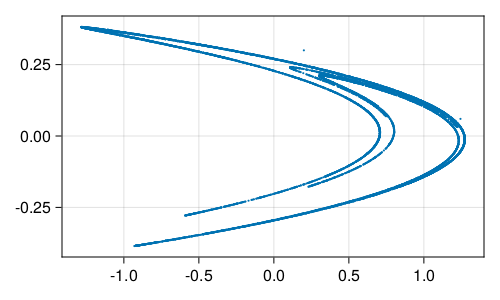

In [9]:
using CairoMakie
scatter(X[:, 1], X[:, 2]; markersize = 3)


### Example: Lorenz96

Let's also make another dynamical system, the Lorenz96 model:
$$
\frac{dx_i}{dt} = (x_{i+1}-x_{i-2})x_{i-1} - x_i + F
$$
for $i \in \{1, \ldots, N\}$ and $N+j=j$.

Here, instead of a discrete time map we have $N$ coupled ordinary differential equations. However, creating the dynamical system works out just like above, but using `CoupledODEs` instead of `DeterministicIteratedMap`.

First, we make the dynamic rule function. Since this dynamical system can be arbitrarily high-dimensional, we prefer to use the _in-place_ form for `f`, overwriting in place the rate of change in a pre-allocated container.

In [10]:
function lorenz96_rule!(du, u, p, t)
    F = p[1]; N = length(u)
    # 3 edge cases
    du[1] = (u[2] - u[N - 1]) * u[N] - u[1] + F
    du[2] = (u[3] - u[N]) * u[1] - u[2] + F
    du[N] = (u[1] - u[N - 2]) * u[N - 1] - u[N] + F
    # then the general case
    for n in 3:(N - 1)
        du[n] = (u[n + 1] - u[n - 2]) * u[n - 1] - u[n] + F
    end
    return nothing # always `return nothing` for in-place form!
end

lorenz96_rule! (generic function with 1 method)

then, like before, we define an initial state and parameters, and initialize the system

In [11]:
N = 6
u0 = range(0.1, 1; length = N)
p0 = [24.0]
lorenz96 = CoupledODEs(lorenz96_rule!, u0, p0)

6-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      true
 dynamic rule:  lorenz96_rule!
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [24.0]
 time:          0.0
 state:         [0.1, 0.28, 0.46, 0.64, 0.82, 1.0]


and, again like before, we may obtain a trajectory the same way


In [12]:
total_time = 12.5
sampling_time = 0.02
Y, t = trajectory(lorenz96, total_time; Ttr = 2.2, Δt = sampling_time)
Y

6-dimensional StateSpaceSet{Float64} with 626 points
 15.8855    19.5112    7.3668    13.2459    6.79653   2.37278
 16.8209    20.8966    6.11778   11.5885    6.14336   3.29582
 18.1219    21.3415    3.72112   10.339     6.24503   4.49973
 19.7163    20.217     0.467733   9.99447   7.21475   6.05166
 21.2618    16.9184   -2.89403   10.5053    9.22228   8.07065
 21.9258    11.1997   -5.43479   11.0319   12.4349   10.7038
 20.2099     3.69898  -6.4271    10.4324   16.6115   13.9645
 14.3808    -3.53315  -5.8574     8.38245  20.8655   17.1785
  4.34713   -7.44291  -5.01403    5.66361  24.1937   18.4256
 -6.50515   -6.31337  -5.2126     2.78556  26.0853   15.7733
  ⋮                                                   ⋮
  5.8074    -8.93493  10.8488     7.10775   2.21914   8.99899
  4.2223    -8.11724  10.5332     9.74335   2.37474   9.13796
  2.76746   -7.40948   9.65881   12.0779    2.58649   9.06597
  1.4447    -6.78048   8.39965   14.081     2.98246   8.75623
  0.251809  -6.18269   6.900

We can't scatterplot something 6-dimensional but we can visualize all timeseries


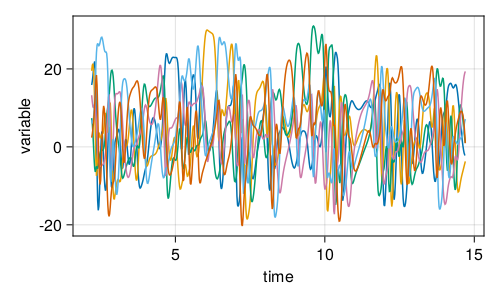

In [13]:
fig = Figure()
ax = Axis(fig[1,1]; xlabel = "time", ylabel = "variable")
for var in columns(Y)
    lines!(ax, t, var)
end
fig


### ODE solving & choosing a solver

Continuous time dynamical systems are evolved through DifferentialEquations.jl using the `OrdinaryDiffEq` module.
When initializing a `CoupledODEs` you can tune the solver properties to your heart's content using any of the [100s of ODE solvers](https://diffeq.sciml.ai/latest/solvers/ode_solve/) and any of the [common solver options](https://diffeq.sciml.ai/latest/basics/common_solver_opts/). For example:


In [14]:
using OrdinaryDiffEq # accessing the ODE solvers
diffeq_precise = (alg = Vern9(), abstol = 1e-9, reltol = 1e-9)
lorenz96_vern = CoupledODEs(lorenz96_rule!, u0, p0; diffeq = diffeq_precise)

6-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      true
 dynamic rule:  lorenz96_rule!
 ODE solver:    Vern9
 ODE kwargs:    (abstol = 1.0e-9, reltol = 1.0e-9)
 parameters:    [24.0]
 time:          0.0
 state:         [0.1, 0.28, 0.46, 0.64, 0.82, 1.0]


In [15]:
Y, t = trajectory(lorenz96_vern, total_time; Ttr = 2.2, Δt = sampling_time)
Y[end]

6-element SVector{6, Float64} with indices SOneTo(6):
 21.90191127612278
 18.233510999163723
 14.589395859813145
 -1.5914358581751
 -6.128985559405487
  8.376204598375525

The choice of the solver algorithm can have **huge impact on the performance and stability of the ODE integration!**

### Higher accuracy, higher order

The solver `Tsit5` (the default solver) is most performant when medium-high error tolerances are requested. When we require very small errors, choosing a different solver can be more accurate. This can be especially impactful for chaotic dynamical systems. Let's first expliclty ask for a given accuracy when solving the ODE by passing the keywords `abstol, reltol` (for absolute and relative tolerance respectively):


In [ ]:
for alg in (Tsit5(), Vern9())
    diffeq = (; alg, abstol = 1e-12, reltol = 1e-12)
    lorenz96 = CoupledODEs(lorenz96_rule!, u0, p0; diffeq)
    @btime trajectory(lorenz96, 100.0)
end

### Stiff problems

A "stiff" ODE problem is one that can be numerically unstable unless the step size (or equivalently, the step error tolerances) are extremely small. There are several situations where a problem may be come "stiff":

- The derivative values can get very large for some state values.
- There is a large _timescale separation_ between the dynamics of the variables
- There is a large _timescale separation_ between the dynamics of different state space regions

One must be aware whether this is possible for their system and choose a solver that is better suited to tackle stiff problems. If not, a solution may diverge and the ODE integrator will throw an error or a warning.

Many of the problems in DifferentialEquations.jl are suitable for dealing with stiff problems. We can create a stiff problem by using the well known Van der Pol  oscillator _with a timescale separation_:

$$
\begin{aligned}
\dot{x} & = y \\
\dot{y} /  \mu &= (1-x^2)y - x
\end{aligned}
$$

with $\mu$ being the timescale of the $y$ variable in units of the timescale of the $x$ variable. For very large values of $\mu$ this problem becomes stiff.

In [1]:
function vanderpol_rule(u, μ, t)
    x, y = u
    dx = y
    dy = μ*((1-x^2)*y - x)
    return SVector(dx, dy)
end

μ = 1e6
for alg in (Tsit5(), Rodas5P())
    diffeq = (; alg, abstol = 1e-12, reltol = 1e-12, saveat = 0.01, maxiters = typemax(Int))
    ds = CoupledODEs(vanderpol_rule, SVector(1.0, 1.0), μ; diffeq)
    @btime trajectory(ds, 100.0)
end

LoadError: LoadError: UndefVarError: `@btime` not defined
in expression starting at c:\Users\gd419\OneDrive - University of Exeter\Teaching\NonlinearDynamicsComplexSystemsCourses\notebooks\dynamicalsystems_intro.ipynb:12

We see that the stiff solver `Rodas5P` is much faster than the default `Tsit5` when there is a large timescale separation. This happened because `Rodas5P` required much less steps to integrated the same total amount of time. In fact, there are cases where regular solvers will _fail_ to integrate the ODE if the problem is very stiff, e.g. in the [ROBER example](https://docs.sciml.ai/SciMLBenchmarksOutput/stable/StiffODE/ROBER/).

## State space sets


Let's recall that the output of the `trajectory` function is a `StateSpaceSet`:


In [16]:
X

2-dimensional StateSpaceSet{Float64} with 10001 points
  0.2        0.3
  1.244      0.06
 -1.10655    0.3732
 -0.341035  -0.331965
  0.505208  -0.102311
  0.540361   0.151562
  0.742777   0.162108
  0.389703   0.222833
  1.01022    0.116911
 -0.311842   0.303065
  ⋮         
 -0.582534   0.328346
  0.853262  -0.17476
 -0.194038   0.255978
  1.20327   -0.0582113
 -1.08521    0.36098
 -0.287758  -0.325562
  0.558512  -0.0863275
  0.476963   0.167554
  0.849062   0.143089

It is printed like a matrix where each column is the timeseries of each dynamic variable. In reality, it is a vector of statically sized vectors (for performance reasons). When indexed with 1 index, it behaves like a vector of vectors


In [17]:
X[1]

2-element SVector{2, Float64} with indices SOneTo(2):
 0.2
 0.3

In [18]:
X[2:5]

2-dimensional StateSpaceSet{Float64} with 4 points
  1.244      0.06
 -1.10655    0.3732
 -0.341035  -0.331965
  0.505208  -0.102311

When indexed with two indices, it behaves like a matrix


In [19]:
X[2:5, 2]

4-element Vector{Float64}:
  0.06
  0.3732
 -0.3319651199999999
 -0.10231059085086688

When iterated, it iterates over the contained points

In [20]:
for (i, point) in enumerate(X)
    @show point
    i > 5 && break
end

point = [0.2, 0.3]
point = [1.244, 0.06]
point = [-1.1065503999999997, 0.3732]
point = [-0.34103530283622296, -0.3319651199999999]
point = [0.5052077711071681, -0.10231059085086688]
point = [0.5403605603672313, 0.1515623313321504]


In [21]:
map(point -> point[1] + point[2], X)

10001-element Vector{Float64}:
  0.5
  1.304
 -0.7333503999999997
 -0.6730004228362229
  0.40289718025630117
  0.6919228916993818
  0.9048851501617762
  0.6125365596336813
  1.1271278272148746
 -0.008777065619615998
  ⋮
 -0.2541879392427324
  0.678501271515278
  0.061940665344374896
  1.145056192451011
 -0.7242249528790483
 -0.6133198017049188
  0.47218423998951875
  0.6445165778497133
  0.9921511619004666

The columns of the set are obtained with the convenience `columns` function

In [22]:
x, y = columns(X)
summary.((x, y))

("10001-element Vector{Float64}", "10001-element Vector{Float64}")

## Using dynamical systems


You may use the `DynamicalSystem` interface to develop algorithms that utilize dynamical systems with a known evolution rule. The two main packages of the library that do this are `ChaosTools` and `Attractors`. For example, you may want to compute the Lyapunov spectrum of the Lorenz96 system from above. This is as easy as calling the `lyapunovspectrum` function with `lorenz96`

In [23]:
lorenz96

6-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      true
 dynamic rule:  lorenz96_rule!
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [24.0]
 time:          14.710810737376262
 state:         [-1.753056852918322, -3.4380749306288965, 0.3972507829867397, 19.484434620997174, 7.209748937694574, -0.44850309369562646]


In [24]:
steps = 10_000
lyapunovspectrum(lorenz96, steps)

6-element Vector{Float64}:
  2.785784477374887
  0.05438023149355024
 -0.048103107629459435
 -0.9775984507216222
 -1.9767558439078472
 -5.837704760813228

As expected, there is at least one positive Lyapunov exponent (because the system is chaotic) and at least one zero Lyapunov exponent, because the system is continuous time.

In [25]:
henon

2-dimensional DeterministicIteratedMap
 deterministic: true
 discrete time: true
 in-place:      false
 dynamic rule:  henon_rule
 parameters:    [1.4, 0.3]
 time:          10000
 state:         [0.8490622425588493, 0.14308891934161724]


In [26]:
lyapunovspectrum(henon, steps)

2-element Vector{Float64}:
  0.4167659070649148
 -1.6207387113908505

Alternatively, you may want to estimate the basins of attraction of a multistable dynamical system. The Henon map is "multistable" in the sense that some initial conditions diverge to infinity, and some others converge to a chaotic attractor. Computing these basins of attraction is simple with [`Attractors`](@ref), and would work as follows:

In [27]:
# define a state space grid to compute the basins on:
xg = yg = range(-2, 2; length = 201)
# find attractors using recurrences in state space:
grid = (xg, yg)
mapper = AttractorsViaRecurrences(henon, grid)
# compute the full basins of attraction over a given grid
basins, attractors = basins_of_attraction(mapper, grid; show_progress = false)
basins

201×201 Matrix{Int32}:
 -1  -1  -1  -1  -1  -1  -1  -1  -1  …  -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1  …  -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
  ⋮                   ⋮              ⋱               ⋮                   ⋮
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -

In [28]:
attractors

Dict{Int32, StateSpaceSet{2, Float64}} with 1 entry:
  1 => 2-dimensional StateSpaceSet{Float64} with 511 points

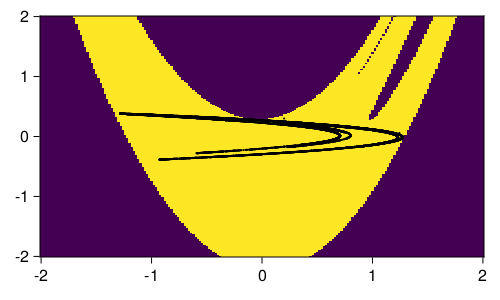

In [29]:
fig, ax = heatmap(xg, yg, basins)
x, y = columns(X) # attractor of Henon map
scatter!(ax, x, y; color = "black", markersize = 3)
fig

## Using state space sets

Several packages of the library deal with `StateSpaceSets`.

You could use `ComplexityMeasures` to obtain the entropy, or other complexity measures, of a given set. Below, we obtain the entropy of the natural density of the chaotic attractor by partitioning into a histogram of approximately `50` bins per dimension:


In [30]:
X

2-dimensional StateSpaceSet{Float64} with 10001 points
  0.2        0.3
  1.244      0.06
 -1.10655    0.3732
 -0.341035  -0.331965
  0.505208  -0.102311
  0.540361   0.151562
  0.742777   0.162108
  0.389703   0.222833
  1.01022    0.116911
 -0.311842   0.303065
  ⋮         
 -0.582534   0.328346
  0.853262  -0.17476
 -0.194038   0.255978
  1.20327   -0.0582113
 -1.08521    0.36098
 -0.287758  -0.325562
  0.558512  -0.0863275
  0.476963   0.167554
  0.849062   0.143089

In [31]:
prob_est = ValueHistogram(50)
entropy(prob_est, X)

7.825799208736613

Alternatively, you could use `FractalDimensions` to get the fractal dimensions of the chaotic attractor of the henon map using the Grassberger-Procaccia algorithm:


In [32]:
grassberger_proccacia_dim(X; show_progress = false)

Correlation sum:   2%|█                                 |  ETA: 0:00:05

Correlation sum: 100%|██████████████████████████████████| Time: 0:00:02


1.2232922815092426

Or, you could obtain a recurrence matrix of a state space set with `RecurrenceAnalysis`


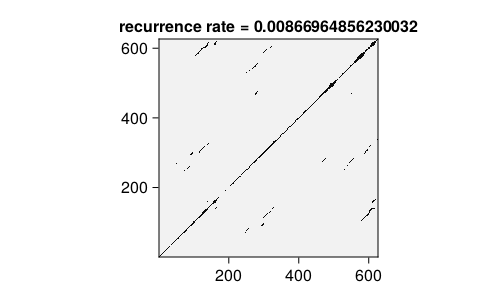

In [33]:
R = RecurrenceMatrix(Y, 8.0)
Rg = grayscale(R)
rr = recurrencerate(R)
heatmap(Rg; colormap = :grays,
    axis = (title = "recurrence rate = $(rr)", aspect = 1,)
)

## More nonlinear timeseries analysis


A `trajectory` of a known dynamical system is one way to obtain a `StateSpaceSet`. However, another common way is via a delay coordinates embedding of a measured/observed timeseries. For example, we could use `optimal_separated_de` from `DelayEmbeddings` to create an optimized delay coordinates embedding of a timeseries


In [34]:
w = Y[:, 1] # first variable of Lorenz96
𝒟, τ, e = optimal_separated_de(w)
𝒟

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.

6-dimensional StateSpaceSet{Float64} with 596 points
 15.8887     20.1992   -15.1915      2.87991   -10.9815      2.42838
 16.8246     14.3614   -11.7755     -0.219967   -9.09056    -2.55429
 18.1259      4.32543   -6.84527    -4.20175    -5.38437    -7.35052
 19.7197     -6.51644   -1.61817    -7.79791    -0.448634  -10.1483
 21.2633    -13.7803     2.34884   -10.2255      3.77238   -10.5318
 21.9228    -16.2554     3.92902   -11.2903      5.00481    -8.92236
 20.1992    -15.1915     2.87991   -10.9815      2.42838    -6.13215
 14.3614    -11.7755    -0.219967   -9.09056    -2.55429    -3.06834
  4.32543    -6.84527   -4.20175    -5.38437    -7.35052    -0.525076
 -6.51644    -1.61817   -7.79791    -0.448634  -10.1483      1.08311
  ⋮                                                          ⋮
  0.787483   13.1943    23.3024     19.8852     16.7553     10.787
  2.34926    15.5469    23.4897     19.036      16.3663      9.32502
  4.17602    17.7664    23.2237     18.332      15.7988    

and compare

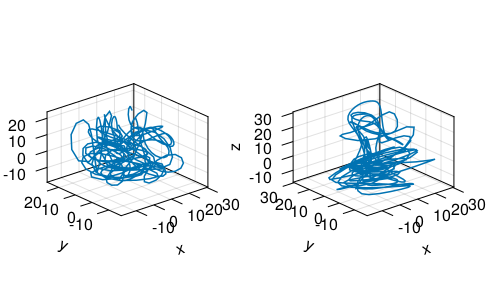

In [35]:
fig = Figure()
axs = [Axis3(fig[1,i]) for i in 1:2]
for (S, ax) in zip((Y, 𝒟), axs)
    lines!(ax, S[:, 1], S[:, 2], S[:, 3])
end
fig

Since `𝒟` is just another state space set, we could be using any of the above analysis pipelines on it just as easily.


The last package to mention here is `TimeseriesSurrogates`, which ties with all other observed/measured data analysis by providing a framework for confidence/hypothesis testing. For example, if we had a measured timeseries but we were not sure whether it represents a deterministic system with structure in the state space, or mostly noise, we could do a surrogate test. For this, we use `surrogenerator` and `RandomFourier` from `TimeseriesSurrogates`, and the `generalized_dim` from `FractalDimensions` (because it performs better in noisy sets)

In [36]:
x = X[:, 1] # Henon map timeseries
# contaminate with noise
using Random: Xoshiro
rng = Xoshiro(1234)
x .+= randn(rng, length(x))/100
# compute noise-contaminated fractal dim.
Δ_orig = generalized_dim(embed(x, 2, 1); show_progress = false)

Entropy calculation:  12%|████                          |  ETA: 0:00:02

Entropy calculation: 100%|██████████████████████████████| Time: 0:00:00


1.3801073957979793

And we do the surrogate test


In [37]:
surrogate_method = RandomFourier()
sgen = surrogenerator(x, surrogate_method, rng)

Δ_surr = map(1:1000) do i
    s = sgen()
    S = embed(s, 2, 1)
    generalized_dim(S; show_progress = false)
end

1000-element Vector{Float64}:
 1.8297218640748234
 1.8449246422077097
 1.8279984137688565
 1.8301078704767055
 1.8107042515928138
 1.8324978359364616
 1.8300954188512213
 1.8416570396197236
 1.8575804541517373
 1.821435647618282
 ⋮
 1.8768262063119583
 1.8287938131092198
 1.8435474417451545
 1.8129026565563846
 1.8551700924677899
 1.828337822527405
 1.8211346475312704
 1.8369834750865566
 1.8368699339310754

and visualize the test result


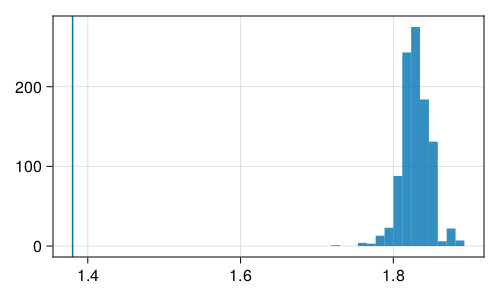

In [38]:
fig, ax = hist(Δ_surr)
vlines!(ax, Δ_orig)
fig

since the real value is outside the distribution we have confidence the data are not pure noise.

# Interactive GUI windows for dynamical systems

DynamicalSystems.jl provides some interactive applications for studying dynamical systems. These come into scope once using `DynamicalSystems` along with a Makie backend. The most useful of this applications is `interactive_trajectory`: it allows interactively evolving a dynamical system, and interactively changing its parameters. It is straightforward to use, and in principle we need three inputs:

1. A dynamical system instance
2. (optional) A set of initial states to evolve from
3. (optional) A set of parameters whose values we would like to control interactively

For this example, let's use the famous Lorenz-63 system:

$$
\begin{aligned}
\dot{X} &= \sigma(Y-X) \\
\dot{Y} &= -XZ + \rho X -Y \\
\dot{Z} &= XY - \beta Z
\end{aligned}
$$

In [39]:
using DynamicalSystems

@inbounds function lorenz_rule(u, p, t)
    du1 = p[1]*(u[2]-u[1])
    du2 = u[1]*(p[2]-u[3]) - u[2]
    du3 = u[1]*u[2] - p[3]*u[3]
    return SVector{3}(du1, du2, du3)
end

u0 = [10.0, 0.0, 15.0]
σ = 10.0; ρ = 28.0; β = 8/3
p0 = [σ, ρ, β]
lorenz = CoupledODEs(lorenz_rule, u0, p0)

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  lorenz_rule
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [10.0, 28.0, 2.6666666666666665]
 time:          0.0
 state:         [10.0, 0.0, 15.0]


The initial conditions can be somewhat arbitrary, and if not given, `initial_state(ds)` is used.

In [40]:
u0s = [u0, u0 .- ones(3), [0.0, 10.0, 15.0], [-2.0, -2.0, 0.1]]

4-element Vector{Vector{Float64}}:
 [10.0, 0.0, 15.0]
 [9.0, -1.0, 14.0]
 [0.0, 10.0, 15.0]
 [-2.0, -2.0, 0.1]

To specify what parameters we would like to change during the time evolution, we must provide a dictionary that maps the parameter _keys_ (same keys as those given to `set_parameter!`) to _ranges of possible values_ for each parameter. In the current example, we would like to be able to change all three parameters:

In [41]:
parameter_sliders = Dict(
    1 => 1:0.1:30,
    2 => 10:0.1:50,
    3 => 1:0.01:10.0,
)

# We can also provide a dictionary mapping keys to names
parameter_names = Dict(1 => "σ", 2 => "ρ", 3 => "β")

Dict{Int64, String} with 3 entries:
  2 => "ρ"
  3 => "β"
  1 => "σ"

These three ingredients can now be given to `interactive_trajectory`. To bring the function into scope, we load `GLMakie`, and we also set `GLMakie` to its non-inline mode, so that an interactive window can pop up that we can click and drag sliders:

In [42]:
using GLMakie
GLMakie.activate!(inline = false)

fig, dsobs = interactive_trajectory(lorenz, u0s;
    parameter_sliders, parameter_names
)

nothing

The function returned two things, the figure (that we have to call `display` on to actually launch the interactive window), and a "dynamical system observable" object, which allows creating custom interactive applications, but is too advanced for current lecture.

In [43]:
display(fig)

GLMakie.Screen(...)

And now we can play around with this window!

# Exercises - DynamicalSystems.jl intro

## Chaotic and not chaotic parametric regimes

Consider the Roessler continuous time dynamical system :
$$

\begin{align}
\dot{x} &= -y-z \\
\dot{y} &= x+ay \\
\dot{z} &= b + z(x-c)
\end{align}
$$

with initial parameters `p = [0.2, 0.2, 3.0] = a, b, c`. Use `u0 = [1, -2, 0.1]` as the initial condition always. 

Initialize a `DynamicalSystem` for the Roessler system. Then, vary the parameters $a \in (0, 1), c \in (0. 10)$ to produce a heatmap of the maximum Lyapunov exponent values versus the two parameters. Identify parameter values where the Roessler system is chaotic, i.e., it has positive Lyapunov exponent.

_Hint: use the keyword `Ttr` in `lyapunov` to evolve the system for a transient amount of time before initializing the estimation of the Lyapunov exponent._

## Ikeda map fractal dimension

Define and simulate the discrete time Ikeda map:
$$
\begin{aligned}
t &= c - \frac{d}{1 + x_n^2 + y_n^2} \\
x_{n+1} &= a + b(x_n \cos(t) - y_n\sin(t)) \\
y_{n+1} &= b(x_n\sin(t) + y_n \cos(t))
\end{aligned}
$$
with initial condition `u = ones(2)` and parameters `p = [6, 0.9, 3.1, 6] = a, b, c, d`. For these initial parameters the system generates an absolutely stunning attractor that has two seemingly separated components!

Simulate the attractor by evolving a trajectory of the system, which will give you a state space set `A`. Scatter plot the two columns of `A`. Then calculate its fractal dimension using the `grassberger_proccacia_dim` function. This function provides an _automated_ algorithm to estimate a fractal dimension. In a realistic application scenario, you should not use the automated function and instead examine careful the steps the automated function does. But for now we use the automated stuff!

Then process the state space set `A` containing the attractor so that you can generate two new state space sets: one with all points with x coordinate less than 2.5, and one with x more than 2.5. Compute the fractal dimension for the two subsets. Is any set more "fractal" than the other (i.e., it has higher fractal dimension)?

## Live exploration of a dynamical system

Consider the Roessler dynamical system
$$
\begin{aligned}
\dot{x} &= -y-z \\
\dot{y} &= x+ay \\
\dot{z} &= b + z(x-c)
\end{aligned}
$$

and consider two initial conditions _set_ to:
```julia
u0s = [
    [-1.25, -0.72, -0.1], 
    [0.72, 1.28, 0.21]
]
```

Use the interactive timeevolution GUI app to explore this dynamical system. 
Allow the system parameters to range from $a \in (0, 1), b \in (0, 1), c \in (0, 10)$. Explore various combinations of parameters, until you find a combination where the system is _multistable_: each of the two initial conditions goes to a different attractor.

_Hint: reset the time-evolution after you change parameters, to ensure that the system state starts from the provided initial conditions._